Exercise 5

The Static Map

In [1]:
# First, the necessary modules are imported:
import geopandas as gpd
import pandas as pd
from pyproj import CRS
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx

# Then the filepaths are defined for the three data sources:
jumbo_fp = 'data/TravelTimes_to_5878070_Jumbo.txt'
roads_fp = 'data/roads.shp'
grid_fp = 'data/YKRgrid/MetropAccess_YKR_grid_EurefFIN.shp'

# The files are read to Pandas / GeoPandas:
jumbo = pd.read_csv(jumbo_fp, sep=';')
roads = gpd.read_file(roads_fp)
grid = gpd.read_file(grid_fp)
roads = roads.to_crs(epsg=3067) # the coordinate system is changed

# The result is checked:
assert roads.crs == grid.crs, "The coordinate systems do not match."

In [2]:
# Joining the grid and the jumbo-dataframe:
jumbo_grid = grid.merge(jumbo, left_on='YKR_ID', right_on='from_id')

# Checking that the type of the new dataframe is correct:
assert type(jumbo_grid) == gpd.geodataframe.GeoDataFrame, "Output should be a geodataframe."

In [3]:
# Values of -1 are changed to no data and then dropped:
jumbo_grid.replace(to_replace=-1, value=np.nan, inplace=True)
jumbo_grid.dropna(inplace=True)
jumbo_grid

,x,y,YKR_ID,geometry,from_id,to_id,walk_t,walk_d,car_r_t,car_r_d,car_m_t,car_m_d,pt_r_t,pt_r_tt,pt_r_d,pt_m_t,pt_m_tt,pt_m_d
0,381875.0,6697880.0,5785640,"POLYGON ((382000.000 6697750.000, 381750.000 6...",5785640,5878070.0,318.0,22279.0,39.0,23233.0,34.0,23233.0,101.0,131.0,24276.0,106.0,138.0,22627.0
1,382125.0,6697880.0,5785641,"POLYGON ((382250.000 6697750.000, 382000.000 6...",5785641,5878070.0,281.0,19662.0,39.0,23444.0,34.0,23444.0,108.0,129.0,26134.0,109.0,137.0,22833.0
2,382375.0,6697880.0,5785642,"POLYGON ((382500.000 6697750.000, 382250.000 6...",5785642,5878070.0,282.0,19742.0,45.0,17666.0,41.0,17666.0,109.0,129.0,26251.0,111.0,137.0,22951.0
3,382625.0,6697880.0,5785643,"POLYGON ((382750.000 6697750.000, 382500.000 6...",5785643,5878070.0,286.0,20034.0,46.0,24695.0,40.0,24698.0,114.0,138.0,26544.0,115.0,141.0,23244.0
4,381125.0,6697630.0,5787544,"POLYGON ((381250.000 6697500.000, 381000.000 6...",5787544,5878070.0,311.0,21789.0,38.0,22807.0,33.0,22807.0,98.0,115.0,25438.0,90.0,113.0,22138.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13225,372625.0,6665630.0,6016697,"POLYGON ((372750.000 6665500.000, 372500.000 6...",6016697,5878070.0,466.0,32617.0,57.0,38627.0,49.0,38605.0,111.0,123.0,39925.0,102.0,124.0,38893.0
13226,372875.0,6665630.0,6016698,"POLYGON ((373000.000 6665500.000, 372750.000 6...",6016698,5878070.0,464.0,32472.0,58.0,38658.0,51.0,38635.0,109.0,123.0,39779.0,100.0,124.0,38748.0
13227,373125.0,6665630.0,6016699,"POLYGON ((373250.000 6665500.000, 373000.000 6...",6016699,5878070.0,466.0,32599.0,60.0,38345.0,53.0,38323.0,110.0,123.0,39907.0,101.0,124.0,38875.0
13229,372625.0,6665380.0,6018253,"POLYGON ((372750.000 6665250.000, 372500.000 6...",6018253,5878070.0,469.0,32829.0,59.0,38835.0,51.0,38812.0,114.0,123.0,40136.0,105.0,124.0,39105.0


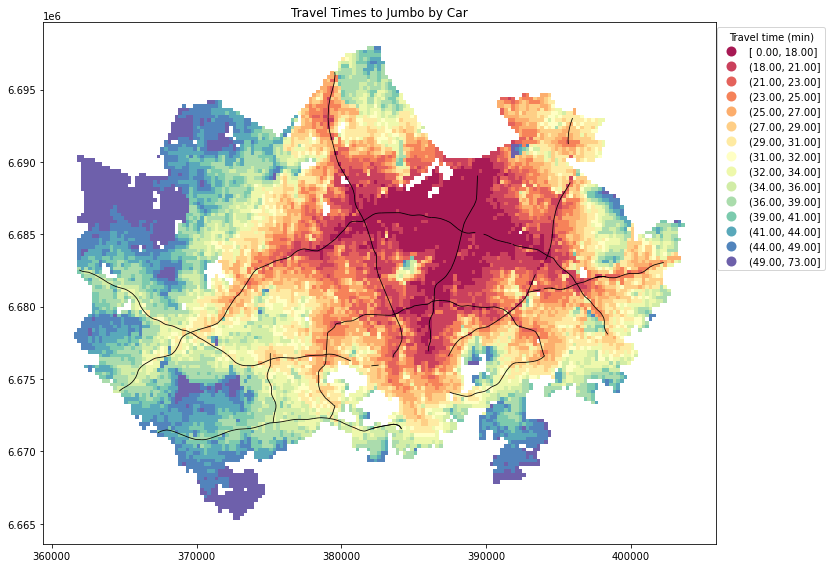

In [20]:
# A subplot is created:
fig, ax = plt.subplots(figsize=(12,8))

# The travel times are visualised into 15 classes:
jumbo_grid.plot(ax=ax, column="car_r_t", 
                linewidth=0.03, 
                cmap="Spectral", 
                scheme="quantiles", 
                k=15, 
                alpha=0.9,
                legend=True)
ax.set_title('Travel Times to Jumbo by Car')
ax.get_legend().set_bbox_to_anchor((1.17,1)) # repositioning the legend
ax.get_legend().set_title('Travel time (min)') # setting the title
plt.tight_layout() # extra white space is removed

# The roads are added on top:
roads.plot(ax=ax, color="black", linewidth=0.8)

# The figure is saved:
plt.savefig("jumbo-car.png")

Interactive Map

In [22]:
# The necessary modules are imported:
import folium
import requests
import geojson

# The URL is assigned to a new variable:
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format).
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018',
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
data = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

# Check the data
data.head()

,geometry,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80
0,MULTIPOLYGON Z (((25476499.999 6674248.999 0.0...,3342,108,45,11,23,6,7,26,17,8,6,4
1,MULTIPOLYGON Z (((25476749.997 6674498.998 0.0...,3503,273,35,35,24,52,62,40,26,25,9,0
2,MULTIPOLYGON Z (((25476999.994 6675749.004 0.0...,3660,239,34,46,24,24,45,33,30,25,10,2
3,MULTIPOLYGON Z (((25476999.994 6675499.004 0.0...,3661,202,30,52,37,13,36,43,11,4,3,3
4,MULTIPOLYGON Z (((25476999.994 6675249.005 0.0...,3662,261,30,64,32,36,64,34,20,6,3,2
